In [1]:
#@title グーグルドライブへ接続
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab Notebooks/DLBasics2023_colab/Final/dl_lecture_competition_pub/

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/DLBasics2023_colab/Final/dl_lecture_competition_pub


In [3]:
%cd /content/drive/MyDrive/Colab Notebooks/DLBasics2023_colab/Final/dl_lecture_competition_pub/data/train
!ls -1 | wc -l

%cd /content/drive/MyDrive/Colab Notebooks/DLBasics2023_colab/Final/dl_lecture_competition_pub/data/valid

#!ls -la 19873 4969 24842のデータの内，80%(19873)が訓練データ，20%(4969)
!ls -1 | wc -l

/content/drive/MyDrive/Colab Notebooks/DLBasics2023_colab/Final/dl_lecture_competition_pub/data/train
19873
/content/drive/MyDrive/Colab Notebooks/DLBasics2023_colab/Final/dl_lecture_competition_pub/data/valid
4969


In [4]:
#@title 各種ライブラリのインポート
import re
import random
import time
import os

from statistics import mode

import numpy as np
import pandas

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms

from PIL import Image
import pickle
import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg

from collections import Counter

In [5]:
#@title trainデータの中身の確認
base='/content/drive/MyDrive/Colab Notebooks/DLBasics2023_colab/Final/dl_lecture_competition_pub'
path =base + "/data/train.json"
df = pandas.read_json(path)
df

,image,question,answers
0,train_00000.jpg,What is this?,"[{'answer_confidence': 'yes', 'answer': 'beef ..."
1,train_00001.jpg,maybe it's because you're pushing it down instead,"[{'answer_confidence': 'yes', 'answer': 'unans..."
2,train_00002.jpg,What color is this item?,"[{'answer_confidence': 'yes', 'answer': 'grey'..."
3,train_00003.jpg,Can you tell me if this is like body wash or l...,"[{'answer_confidence': 'maybe', 'answer': 'lot..."
4,train_00004.jpg,Is it a paper?,"[{'answer_confidence': 'yes', 'answer': 'no'},..."
...,...,...,...
19868,train_19868.jpg,What's on this card please?,"[{'answer_confidence': 'yes', 'answer': 'unans..."
19869,train_19869.jpg,I can't tell what it is that I'm holding.,"[{'answer_confidence': 'yes', 'answer': 'finge..."
19870,train_19870.jpg,What does it say on this shirt?,"[{'answer_confidence': 'yes', 'answer': 'hands..."
19871,train_19871.jpg,I'm looking for the model number of this print...,"[{'answer_confidence': 'yes', 'answer': 'unans..."


In [6]:
#@title answersデータの中身の確認
df['answers'][0]

[{'answer_confidence': 'yes', 'answer': 'beef chuck steak'},
 {'answer_confidence': 'yes', 'answer': 'beef chuck steak'},
 {'answer_confidence': 'yes', 'answer': 'beef chuck steak'},
 {'answer_confidence': 'yes', 'answer': 'beef chuck steak'},
 {'answer_confidence': 'yes', 'answer': 'flat iron beef chuck steak'},
 {'answer_confidence': 'yes', 'answer': 'beef chuck steak'},
 {'answer_confidence': 'yes', 'answer': 'steak'},
 {'answer_confidence': 'yes', 'answer': 'flat iron beef chuck steak'},
 {'answer_confidence': 'yes', 'answer': 'beef chuck steak'},
 {'answer_confidence': 'yes', 'answer': 'beef chuck steak'}]

In [7]:
#@title validデータの中身の確認
base='/content/drive/MyDrive/Colab Notebooks/DLBasics2023_colab/Final/dl_lecture_competition_pub'
path =base + "/data/valid.json"
df2 = pandas.read_json(path)
df2

,image,question
0,valid_00000.jpg,Was I able to clear either of the mirrors of t...
1,valid_00001.jpg,What page number is this above? Thank you.
2,valid_00002.jpg,Please tell me what is in this box.
3,valid_00003.jpg,Are the lights on in this room?
4,valid_00004.jpg,"What color is this? Please, thank you."
...,...,...
4964,valid_04964.jpg,What is this?
4965,valid_04965.jpg,How much water and butter is required for this...
4966,valid_04966.jpg,"What kind of soup is this, please?"
4967,valid_04967.jpg,What is this?


In [ ]:
#@title　画像データのインポート
timg = {}
output_file_name = 'train.pkl'
base='/content/drive/MyDrive/Colab Notebooks/DLBasics2023_colab/Final/dl_lecture_competition_pub'

### pickleで保存したファイルを読み込み
with open(base + '/' + output_file_name, mode='br') as fi:
    btimg = pickle.load(fi)


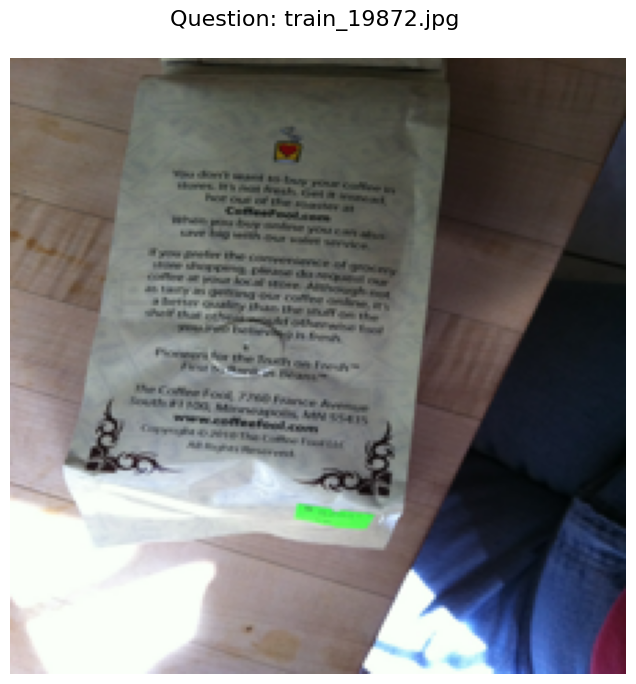

In [ ]:
#@title イメージのサンプル確認
title = 'train_19872.jpg' #'valid_04967.jpg'
image = btimg[title]

plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.title(f"Image: {title} \n", fontsize=16)
plt.axis('off')
plt.show()

In [ ]:
#@title validイメージの読み込み

### pickleで保存したファイルを読み込み
with open(base + '/' + 'valid.pkl', mode='br') as fi:
    validimg = pickle.load(fi)

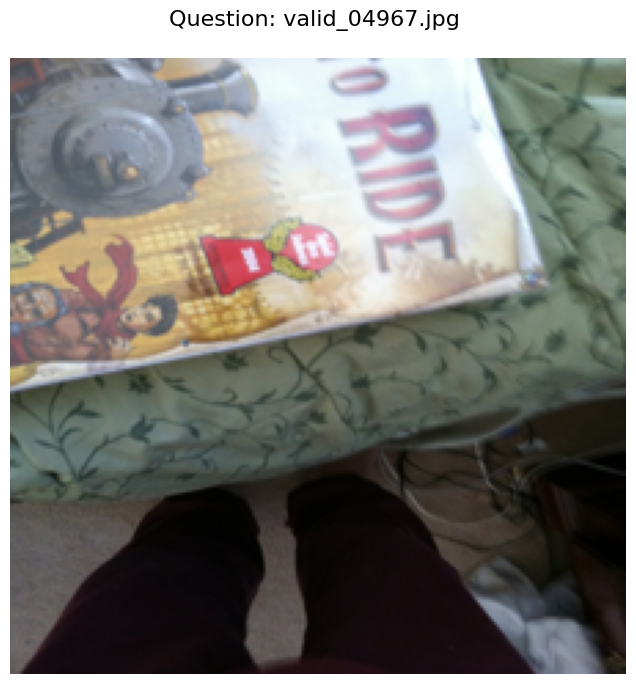

In [ ]:
#@title イメージのサンプル確認
title = 'valid_04967.jpg'
image = validimg[title]
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.title(f"Image: {title} \n", fontsize=16)
plt.axis('off')
plt.show()

In [ ]:
#@title clip関連のインストール
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.4 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-eqz466tu
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-eqz466tu
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_

In [ ]:
#@title clip関連のインストール確認
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [ ]:
#@title clipモデル、トークナイザの確認
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

clip_model, preprocess = clip.load("RN50", device=device)

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in clip_model.parameters()]):,}")
print(f"Input resolution: {clip_model.visual.input_resolution}")
print(f"Context length: {clip_model.context_length}")
print(f"Vocab size: {clip_model.vocab_size}")

cuda:0


100%|████████████████████████████████████████| 244M/244M [00:01<00:00, 139MiB/s]


Model parameters: 102,007,137
Input resolution: 224
Context length: 77
Vocab size: 49408


In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def process_text(text):
    # lowercase
    text = text.lower()

    # 数詞を数字に変換
    num_word_to_digit = {
        'zero': '0', 'one': '1', 'two': '2', 'three': '3', 'four': '4',
        'five': '5', 'six': '6', 'seven': '7', 'eight': '8', 'nine': '9',
        'ten': '10'
    }
    for word, digit in num_word_to_digit.items():
        text = text.replace(word, digit)

    # 小数点のピリオドを削除
    text = re.sub(r'(?<!\d)\.(?!\d)', '', text)

    # 冠詞の削除
    text = re.sub(r'\b(a|an|the)\b', '', text)

    # 短縮形のカンマの追加
    contractions = {
        "dont": "don't", "isnt": "isn't", "arent": "aren't", "wont": "won't",
        "cant": "can't", "wouldnt": "wouldn't", "couldnt": "couldn't"
    }
    for contraction, correct in contractions.items():
        text = text.replace(contraction, correct)

    # 句読点をスペースに変換
    text = re.sub(r"[^\w\s':]", ' ', text)

    # 句読点をスペースに変換
    text = re.sub(r'\s+,', ',', text)

    # 連続するスペースを1つに変換
    text = re.sub(r'\s+', ' ', text).strip()

    return text



class VQADataset2(torch.utils.data.Dataset):
    def __init__(self, df_path, image_dir, transform=None, answer=True):

        self.df = pandas.read_json(df_path)
        self.image_path = image_dir

        def most_common(lst):
          data = Counter(lst)
          return max(lst, key=data.get)

        self.transform = transform

        self.X = torch.empty((len(self.df), 2048), dtype=torch.float32)

        for i in range(len(self.df)):
            image = self.image_path[self.df['image'].iloc[i]].convert('RGB')

            if self.transform is not None:
                image = self.transform(image).unsqueeze(0).to(device)

            question = clip.tokenize(self.df['question'].iloc[i]).to(device)
            with torch.no_grad():
                image_features = clip_model.encode_image(image)
                text_features = clip_model.encode_text(question)
            self.X[i] = torch.cat((image_features, text_features), 1).to(torch.float32)

        self.answer = answer

        # question / answerの辞書を作成
        self.question2idx = {}
        self.answer2idx = {}
        self.idx2question = {}
        self.idx2answer = {}

        # 質問文に含まれる単語を辞書に追加
        for question in self.df["question"]:
            question = process_text(question)
            words = question.split(" ")
            for word in words:
                if word not in self.question2idx:
                    self.question2idx[word] = len(self.question2idx)
        self.idx2question = {v: k for k, v in self.question2idx.items()}  # 逆変換用の辞書(question)

        if self.answer:
            # 回答に含まれる単語を辞書に追加
            for answers in self.df["answers"]:
                for answer in answers:
                    word = answer["answer"]
                    word = process_text(word)
                    if word not in self.answer2idx:
                        self.answer2idx[word] = len(self.answer2idx)
            self.idx2answer = {v: k for k, v in self.answer2idx.items()}  # 逆変換用の辞書(answer)

    def update_dict(self, dataset):
        """
        検証用データ，テストデータの辞書を訓練データの辞書に更新する．

        Parameters
        ----------
        dataset : Dataset
            訓練データのDataset
        """
        self.question2idx = dataset.question2idx
        self.answer2idx = dataset.answer2idx
        self.idx2question = dataset.idx2question
        self.idx2answer = dataset.idx2answer

    def __getitem__(self, idx):

        if self.answer:
            answers = [self.answer2idx[process_text(answer["answer"])] for answer in self.df["answers"][idx]]
            mode_answer_idx = mode(answers)  # 最頻値を取得（正解ラベル）

            return idx, self.X[idx], torch.Tensor(answers), int(mode_answer_idx)

        else:
            return idx, self.X[idx]


    def __len__(self):
        return len(self.df)

# 1. データローダーの作成
class VQADataset(torch.utils.data.Dataset):
    def __init__(self, df_path, image_dir, transform=None, answer=True):
        self.transform = transform  # 画像の前処理
        self.image_dir = image_dir  # 画像ファイルのディレクトリ
        self.df = pandas.read_json(df_path)  # 画像ファイルのパス，question, answerを持つDataFrame
        self.answer = answer

        # question / answerの辞書を作成
        self.question2idx = {}
        self.answer2idx = {}
        self.idx2question = {}
        self.idx2answer = {}

        # 質問文に含まれる単語を辞書に追加
        for question in self.df["question"]:
            question = process_text(question)
            words = question.split(" ")
            for word in words:
                if word not in self.question2idx:
                    self.question2idx[word] = len(self.question2idx)
        self.idx2question = {v: k for k, v in self.question2idx.items()}  # 逆変換用の辞書(question)

        if self.answer:
            # 回答に含まれる単語を辞書に追加
            for answers in self.df["answers"]:
                for answer in answers:
                    word = answer["answer"]
                    word = process_text(word)
                    if word not in self.answer2idx:
                        self.answer2idx[word] = len(self.answer2idx)
            self.idx2answer = {v: k for k, v in self.answer2idx.items()}  # 逆変換用の辞書(answer)

    def update_dict(self, dataset):
        """
        検証用データ，テストデータの辞書を訓練データの辞書に更新する．

        Parameters
        ----------
        dataset : Dataset
            訓練データのDataset
        """
        self.question2idx = dataset.question2idx
        self.answer2idx = dataset.answer2idx
        self.idx2question = dataset.idx2question
        self.idx2answer = dataset.idx2answer

    def __getitem__(self, idx):
        """
        対応するidxのデータ（画像，質問，回答）を取得．

        Parameters
        ----------
        idx : int
            取得するデータのインデックス

        Returns
        -------
        image : torch.Tensor  (C, H, W)
            画像データ
        question : torch.Tensor  (vocab_size)
            質問文をone-hot表現に変換したもの
        answers : torch.Tensor  (n_answer)
            10人の回答者の回答のid
        mode_answer_idx : torch.Tensor  (1)
            10人の回答者の回答の中で最頻値の回答のid
        """
        image = self.image_dir[self.df['image'][idx]]
        #image = Image.open(f"{self.image_dir}/{self.df['image'][idx]}")
        image = self.transform(image)
        question = np.zeros(len(self.idx2question) + 1)  # 未知語用の要素を追加
        q = self.df["question"][idx]
        q = process_text(q)
        question_words = q.split(" ")
        for word in question_words:
            try:
                #question[self.question2idx[process_text(word)]] = 1  # one-hot表現に変換
                question[self.question2idx[word]] = 1  # one-hot表現に変換
            except KeyError:
                question[-1] = 1  # 未知語

        if self.answer:
            answers = [self.answer2idx[process_text(answer["answer"])] for answer in self.df["answers"][idx]]
            mode_answer_idx = mode(answers)  # 最頻値を取得（正解ラベル）

            return image, torch.Tensor(question), torch.Tensor(answers), int(mode_answer_idx)

        else:
            return image, torch.Tensor(question)

    def __len__(self):
        return len(self.df)


# 2. 評価指標の実装
# 簡単にするならBCEを利用する
@torch.jit.script
def VQA_criterion(batch_pred: torch.Tensor, batch_answers: torch.Tensor):
    total_acc = 0.

    for pred, answers in zip(batch_pred, batch_answers):
        acc = 0.
        for i in range(len(answers)):
            num_match = 0
            for j in range(len(answers)):
                if i == j:
                    continue
                if pred == answers[j]:
                    num_match += 1
            acc += min(num_match / 3, 1)
        total_acc += acc / 10

    return total_acc / len(batch_pred)


# 3. モデルのの実装
# ResNetを利用できるようにしておく
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels: int, out_channels: int, stride: int = 1):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        out += self.shortcut(residual)
        out = self.relu(out)

        return out


class BottleneckBlock(nn.Module):
    expansion = 4

    def __init__(self, in_channels: int, out_channels: int, stride: int = 1):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels * self.expansion)
            )

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        out += self.shortcut(residual)
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self, block, layers):
        super().__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, layers[0], 64)
        self.layer2 = self._make_layer(block, layers[1], 128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], 256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], 512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, 512)

    def _make_layer(self, block, blocks, out_channels, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet50():
    return ResNet(BottleneckBlock, [3, 4, 6, 3])


class VQAModel(nn.Module):
    def __init__(self, vocab_size: int, n_answer: int):
        super().__init__()
        self.resnet = ResNet18()
        #self.resnet = ResNet50()
        self.text_encoder = nn.Linear(vocab_size, 512)

        self.fc = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, n_answer)
        )

    def forward(self, image, question):
        image_feature = self.resnet(image)  # 画像の特徴量
        question_feature = self.text_encoder(question)  # テキストの特徴量

        x = torch.cat([image_feature, question_feature], dim=1)
        x = self.fc(x)

        return x



input_dim = 2048
hidden_dim = 2048
output_dim = 9


class VQAModel2(nn.Module):
    def __init__(self, vocab_size: int, n_answer: int):
        #super(VQAModel, self).__init__()
        super().__init__()
        self.fc1 = nn.Linear(2048, 2048)
        #self.fc1 = nn.Linear(vocab_size, 2048)
        self.ln1 = nn.LayerNorm(2048)
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(2048, n_answer)
        self.ln2 = nn.LayerNorm(n_answer)
        self.dropout2 = nn.Dropout(p=0.5)

    def forward(self, image, question):
        # Layer 1
        x = question
        x = self.fc1(x)
        x = self.ln1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        # Layer 2
        x = self.fc2(x)
        x = self.ln2(x)
        x = self.dropout2(x)
        return x

In [ ]:
#@title 学習の実装
def train(model, dataloader, optimizer, criterion, device):
    model.train()

    total_loss = 0
    total_acc = 0
    simple_acc = 0

    start = time.time()
    for image, question, answers, mode_answer in dataloader:

        image, question, answer, mode_answer = \
            image.to(device, non_blocking=True), question.to(device, non_blocking=True), \
             answers.to(device, non_blocking=True), mode_answer.to(device, non_blocking=True)

        pred = model(image, question)
        loss = criterion(pred, mode_answer.squeeze())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += VQA_criterion(pred.argmax(1), answers)  # VQA accuracy
        simple_acc += (pred.argmax(1) == mode_answer).float().mean().item()  # simple accuracy
        #i = i+1
        #print(i)

    return total_loss / len(dataloader), total_acc / len(dataloader), simple_acc / len(dataloader), time.time() - start


def eval(model, dataloader, optimizer, criterion, device):
    model.eval()

    total_loss = 0
    total_acc = 0
    simple_acc = 0

    start = time.time()
    for image, question, answers, mode_answer in dataloader:
        image, question, answer, mode_answer = \
            image.to(device), question.to(device), answers.to(device), mode_answer.to(device)

        pred = model(image, question)
        loss = criterion(pred, mode_answer.squeeze())

        total_loss += loss.item()
        total_acc += VQA_criterion(pred.argmax(1), answers)  # VQA accuracy
        simple_acc += (pred.argmax(1) == mode_answer).mean().item()  # simple accuracy

    return total_loss / len(dataloader), total_acc / len(dataloader), simple_acc / len(dataloader), time.time() - start


In [ ]:
#@title データローダーの準備
set_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"

print(device)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = VQADataset2(df_path=base + "/data/train.json", image_dir=btimg, transform=transform)
test_dataset = VQADataset2(df_path=base + "/data/valid.json", image_dir=validimg, transform=transform, answer=False)

test_dataset.update_dict(train_dataset)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True,num_workers=os.cpu_count(),pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False,num_workers=os.cpu_count(),pin_memory=True)

cuda


In [ ]:
model = VQAModel2(vocab_size=len(train_dataset.question2idx)+1, n_answer=len(train_dataset.answer2idx)).to(device)

num_epoch = 10

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # クロスエントロピー損失の計算
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')

        # 確率の計算
        pt = torch.exp(-BCE_loss)

        # フォーカルロスの計算
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        # 損失の集計
        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss

# 使用例
criterion = FocalLoss(alpha=1, gamma=2)
#criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

#学習の再開（初回の場合はコメントアウト）
checkpoint = torch.load("14.pth")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


# 高速化で追加
torch.backends.cudnn.benchmark = True

# train model
for epoch in range(num_epoch):
    train_loss, train_acc, train_simple_acc, train_time = train(model, train_loader, optimizer, criterion, device)
    print(f"【{epoch + 1}/{num_epoch}】\t"
          f"train time: {train_time:.2f} [s]\t"
          f"train loss: {train_loss:.4f}\t"
          f"train acc: {train_acc:.4f}\t"
          f"train simple acc: {train_simple_acc:.4f}")

# 提出用ファイルの作成
model.eval()
submission = []
for image, question in test_loader:
    image, question = image.to(device), question.to(device)
    pred = model(image, question)
    pred = pred.argmax(1).cpu().item()
    submission.append(pred)

submission = [train_dataset.idx2answer[id] for id in submission]
submission = np.array(submission)
np.save("submission.npy", submission)

#if __name__ == "__main__":


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


【1/10】	train time: 47.91 [s]	train loss: 5.3665	train acc: 0.4739	train simple acc: 0.4622
【2/10】	train time: 47.96 [s]	train loss: 5.3894	train acc: 0.4714	train simple acc: 0.4595
【3/10】	train time: 47.83 [s]	train loss: 5.3773	train acc: 0.4741	train simple acc: 0.4622
【4/10】	train time: 47.73 [s]	train loss: 5.3433	train acc: 0.4730	train simple acc: 0.4638
【5/10】	train time: 47.75 [s]	train loss: 5.3419	train acc: 0.4775	train simple acc: 0.4664
【6/10】	train time: 47.69 [s]	train loss: 5.3644	train acc: 0.4740	train simple acc: 0.4634
【7/10】	train time: 47.78 [s]	train loss: 5.3499	train acc: 0.4754	train simple acc: 0.4654
【8/10】	train time: 47.79 [s]	train loss: 5.3518	train acc: 0.4748	train simple acc: 0.4659
【9/10】	train time: 47.62 [s]	train loss: 5.3650	train acc: 0.4750	train simple acc: 0.4632
【10/10】	train time: 47.89 [s]	train loss: 5.3091	train acc: 0.4801	train simple acc: 0.4694


In [ ]:
#@title 世代の保存
save_path ="15.pth"
torch.save({'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()},
       save_path)

In [ ]:
model

VQAModel2(
  (fc1): Linear(in_features=2048, out_features=2048, bias=True)
  (ln1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=2048, out_features=40244, bias=True)
  (ln2): LayerNorm((40244,), eps=1e-05, elementwise_affine=True)
  (dropout2): Dropout(p=0.5, inplace=False)
)

In [24]:
#@title イメージのpickle化
def toPickleIMG(df,image_dir,output_file_name):
  timg = {}

  start = time.time()           # 測定開始

  # 1列目をループして表示
  for index, row in df.iterrows():
    key = row['image']
    img = Image.open(image_dir + '/' + key)
    img_resize = img.resize((224, 224))
    timg[key] = img_resize
    if index % 1000 == 0 :
      elapsed = time.time() - start # 測定終了
      print(f"{index}:{elapsed:.2f} s")


  #保存
  with open(base + '/' + output_file_name , 'wb') as f:
    pickle.dump(timg, f)

  ### pickleで保存したファイルを読み込み
  with open(base + '/' + output_file_name, mode='br') as fi:
    btimg = pickle.load(fi)

  #最後のイメージを表示
  title = df['image'].iloc[-1]
  image = btimg[title]

  plt.figure(figsize=(8, 8))
  plt.imshow(image)
  plt.title(f"Image: {title} \n", fontsize=16)
  plt.axis('off')
  plt.show()


In [23]:
base='/content/drive/MyDrive/Colab Notebooks/DLBasics2023_colab/Final/dl_lecture_competition_pub'
image_dir = base + '/data/train'

toPickleIMG(df,image_dir,output_file_name = 'train.pkl')

0:0.03 s
1000:29.21 s
2000:59.07 s
3000:88.10 s
4000:117.72 s


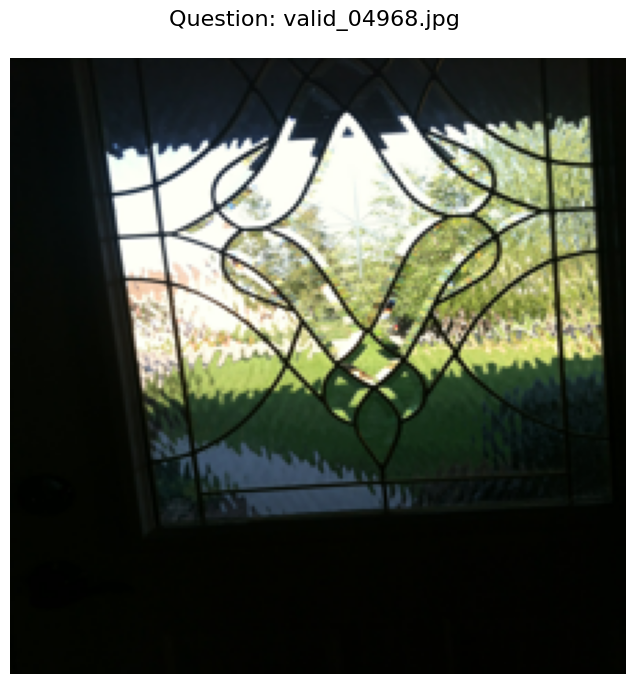

In [21]:
base='/content/drive/MyDrive/Colab Notebooks/DLBasics2023_colab/Final/dl_lecture_competition_pub'
image_dir = base + '/data/valid'

toPickleIMG(df2,image_dir,output_file_name = 'valid.pkl')